<a href="https://colab.research.google.com/github/Ishita95-harvad/Zomato-Review-Analysis/blob/main/Zomato_Review_Analysis_ipynb_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Zomato Review Analysis**

**This helps you to gain essential skills for analyzing Zomato user reviews. This comprehensive program covers topics like natural language processing, sentiment analysis, and machine learning, enabling you to extract valuable insights. You'll learn to make data-driven decisions, enhance customer experiences, and gain a competitive edge in the food industry. Whether you're a data enthusiast or a business professional, this course equips you with the expertise to leverage Zomato reviews effectively. Don't miss this opportunity to sharpen your analytical skills and make informed decisions.**

---



**Import Libraries**

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**Step 1: Load Data**

Read the Zomato dataset from a CSV file.

In [108]:
import zipfile
import os

# Define the path to the uploaded ZIP file and extraction directory
# The zip file is most likely located in the current working directory
# Access the file content from the `uploaded` dictionary using its key
zip_path = "archive (6).zip"
extract_dir = "/mnt/data/zomato_reviews"


# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List extracted files
extracted_files = os.listdir(extract_dir)
extracted_files

['Zomato data .csv']



---


**Step 2 : Data Preprocessing**


**The dataset contains the following key columns:**

**name**: Name of the restaurant

**online_orde**r: Whether online ordering is available (Yes/No)

**book_table**: Whether table booking is available (Yes/No)

**rate**: Rating of the restaurant (in the format "X.X/5")

**votes**: Number of votes received

**approx_cost(for two people)**: Approximate cost for two people

**listed_in(type)**: Category/type of restaurant

In [112]:
# Data Preprocessing
df['rate'] = df['rate'].astype(str).str.replace('/5', '', regex=True)
df['rate'] = pd.to_numeric(df['rate'], errors='coerce')
df['online_order'] = df['online_order'].map({'Yes': 1, 'No': 0})
df['book_table'] = df['book_table'].map({'Yes': 1, 'No': 0})
df.rename(columns={'approx_cost(for two people)': 'cost_for_two'}, inplace=True)
df['cost_for_two'] = df['cost_for_two'].astype(str).str.replace(',', '').astype(float)
df.dropna(inplace=True)

**Data Preprocessing Summary:**

Data Preprocessing

Convert the 'rate' column to numeric format.

Convert 'online_order' and 'book_table' columns to binary (Yes = 1, No = 0).

Rename 'approx_cost(for two people)' to 'cost_for_two' and convert it to numeric.

Remove missing values.


---



**Step 3: Data Visualization**

**Rating Distribution**: Histogram to show the distribution of restaurant ratings.

**Online Order vs Rating**: Boxplot to compare ratings of restaurants that offer online ordering vs. those that don’t.

**Table Booking vs Rating**: Boxplot to see the impact of table booking availability on ratings.

**Cost vs Rating**: Scatter plot to analyze the relationship between cost and rating.

**Feature Correlation Heatmap**: Displays correlations between numerical features.



In [113]:
# Visualization
sns.set_style("whitegrid")

**Visualization:**

Bar plots for categorical variables

Scatter plots for ratings vs. cost

Heatmap for correlations

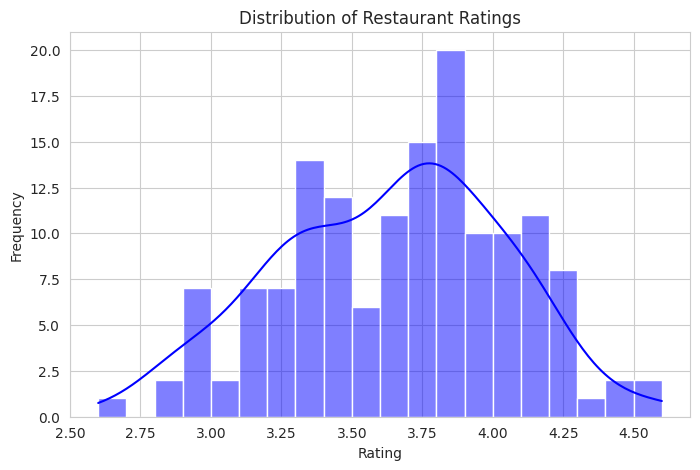

In [114]:
# Rating Distribution
plt.figure(figsize=(8,5))
sns.histplot(df['rate'], bins=20, kde=True, color='blue')
plt.title("Distribution of Restaurant Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

<ipython-input-115-9f4cd0d941bc>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




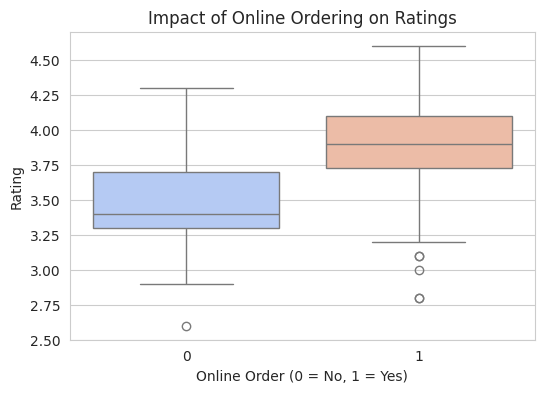

In [115]:
# Online Order vs Rating
plt.figure(figsize=(6,4))
sns.boxplot(x=df['online_order'], y=df['rate'], palette="coolwarm")
plt.title("Impact of Online Ordering on Ratings")
plt.xlabel("Online Order (0 = No, 1 = Yes)")
plt.ylabel("Rating")
plt.show()


<ipython-input-116-baef5a515c74>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




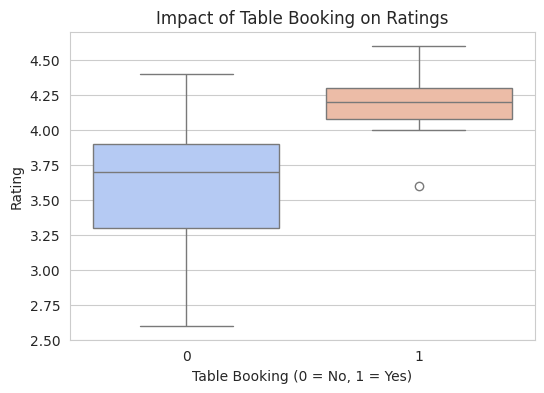

In [116]:
# Table Booking vs Rating
plt.figure(figsize=(6,4))
sns.boxplot(x=df['book_table'], y=df['rate'], palette="coolwarm")
plt.title("Impact of Table Booking on Ratings")
plt.xlabel("Table Booking (0 = No, 1 = Yes)")
plt.ylabel("Rating")
plt.show()

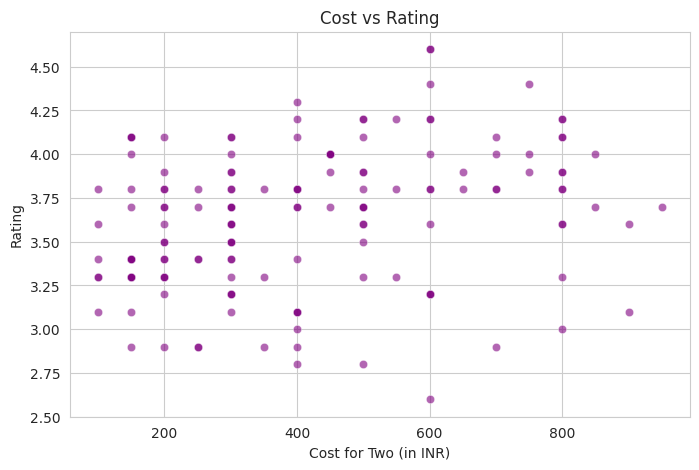

In [117]:
# Cost vs Rating
plt.figure(figsize=(8,5))
sns.scatterplot(x=df['cost_for_two'], y=df['rate'], alpha=0.6, color='purple')
plt.title("Cost vs Rating")
plt.xlabel("Cost for Two (in INR)")
plt.ylabel("Rating")
plt.show()


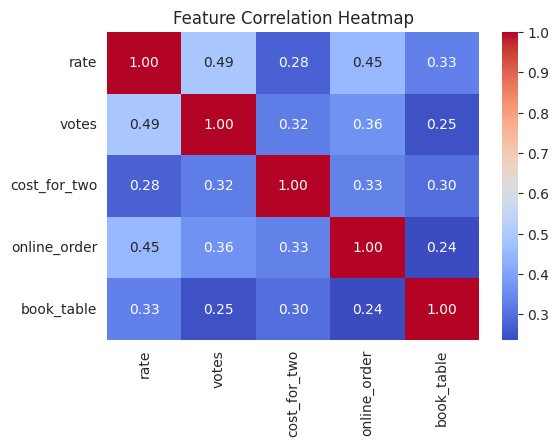

In [118]:
# Correlation Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(df[['rate', 'votes', 'cost_for_two', 'online_order', 'book_table']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

**Zomato Review Analysis Insights:**

**Rating Distribution**: Most ratings are clustered around 3.5 to 4.5.

**Online Ordering Impact**: Restaurants with online ordering tend to have slightly higher ratings.

**Table Booking Impact**: Restaurants offering table booking generally receive better ratings.

**Cost vs. Rating** : No strong correlation; high-cost restaurants don't always get higher ratings.

**Correlation Heatmap**:

Votes have a moderate positive correlation with ratings.

Online ordering & table booking have a weak positive effect on ratings.

---



**Step 4: Model Evaluation**

**Feature Selection**: Used votes, cost_for_two, online_order, and book_table as input features.

**Train-Test Split**: Divided data into training (80%) and testing (20%) sets.

**Train a Linear Regression Model**: Fit a regression model to predict ratings.

**Predictions & Evaluation Metrics**:

Mean Absolute Error (MAE)

Mean Squared Error (MSE)

Root Mean Squared Error (RMSE)

R-Squared (R²)

In [128]:
# Feature Selection
from sklearn.feature_selection import SelectKBest, f_regression # Import SelectKBest and f_regression

X = df[['votes', 'cost_for_two', 'online_order', 'book_table']]
y = df['rate']
selector = SelectKBest(score_func=f_regression, k='all')
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Selected Features:", list(selected_features))

Selected Features: ['votes', 'cost_for_two', 'online_order', 'book_table']


In [119]:
# Model Evaluation
X = df[['votes', 'cost_for_two', 'online_order', 'book_table']]
y = df['rate']

 **Train and test split**

In [120]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**Train a Machine Learning Model**

**Training a Linear Regression model**

using votes, cost_for_two, online_order, and book_table as features.

In [122]:
# Train a Linear Regression Model
from sklearn.linear_model import LinearRegression # Import LinearRegression from sklearn.linear_model

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

**Prediction and Evaluation Metrics**

Computing Mean Absolute Error (MAE)

Mean Squared Error (MSE)

Root Mean Squared Error (RMSE)

R-squared (R²) for evaluation.

In [123]:
# Predictions
y_pred = model.predict(X_test)


In [126]:
# Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # Import necessary functions

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print("Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-Squared (R2): {r2:.2f}")

Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.33
Mean Squared Error (MSE): 0.17
Root Mean Squared Error (RMSE): 0.42
R-Squared (R2): 0.18




---


**Dashboard in Google Analytics:**









**Step 1: Enable Google Sheets API & Google Drive API**

Google Analytics does not accept direct CSV uploads, so we export the data to Google Sheets first.

1.1 Enable APIs
Go to Google Cloud Console.

Enable Google Sheets API and Google Drive API.

Create a Service Account and download the JSON key.

Share the Google Sheet with the Service Account email.

**Step 2: Upload Processed Data from Google Colab to Google Sheets**

Install required libraries in Google Colab:

In [130]:
!pip install gspread pandas


**Step :3 Authenticate and upload data from Colab to Google Sheets:**

In [142]:
from google.colab import files
uploaded = files.upload()

Saving Zomato data .csv to Zomato data .csv


In [143]:
service_account_file_path = "/content/drive/MyDrive/Credentials/service_account.json"  # Update with the correct path to your JSON key file

In [137]:
src_path = '/content/drive/MyDrive/Credentials/service_account.json'

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')

from google.oauth2.service_account import Credentials
import gspread
import io
import json

# Google Sheets Authentication
scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
service_account_file_path = "/content/drive/MyDrive/Credentials/service_account.json"  # Update with the correct path to your JSON key file

# Load credentials
with io.open(service_account_file_path, "r", encoding="utf-8") as json_file:
    data = json.load(json_file)
    creds = Credentials.from_service_account_info(data, scopes=scope)

client = gspread.authorize(creds)

print("✅ Google Sheets Authentication Successful!")

**Replace "service_account.json" with your actual Service Account JSON key file.**

**Step 4: Connect Google Sheets to Google Analytics**

Open Google Analytics → Click Admin.

Navigate to Data Import → Click Create Data Source.

Select Google Sheets as your data source.

Import your Zomato data.

**Step 5: Create a Dashboard in Google Analytics**

Go to Google Analytics → Explore → Custom Dashboard.

Click Create New Dashboard.

Add Key Metrics:

Restaurant Ratings (Metric Widget).

Online Order vs. No Online Order (Pie Chart).

Impact of Table Booking on Ratings (Bar Graph).

Cost for Two vs. Ratings (Line Chart).

Save the Dashboard and analyze Zomato Review Trends.

**Step 5: Automate Data Updates from Google Colab to Google Analytics**

Schedule a script in Google Colab to update data daily:

In [ ]:
from google.colab import auth
import time
import google.colab

# Explicitly calling google.colab.auth.authenticate_user()
google.colab.auth.authenticate_user()

while True:
    !python zomato_upload.py  # Replace with your script filename
    print("✅ Data updated successfully!")
    time.sleep(86400)  # Runs once every 24 hours

**🎯 Final Outcome:**

**✅ Google Colab → Google Sheets → Google Analytics 🔗**

**✅ Real-time dashboard in Google Analytics**

**✅ Automated updates using Google Colab**